# Windspeed in Offshore Environments: 

July 2024  

Here are is an example notebook of using the ERA5 dataset for analyzing the wind conditions in offshore environments. In this notebook, the monthly mean windspeed is plotted for 2023 as an example. The ERA5 dataset available on the cloud has an optimized chunking scheme for training machine learning models that rely on the entire lat/lon domain at each time step. This dataset is therefore not optimized for timeseries analysis. 

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from scipy.stats import weibull_min
from distributed import Client

import kwindy

## Goal: 

If we had offshore windfarms along the U.S. East Coast, would we have seen a change in energy production since 1940? 

#### Methods: 

*Step 1*: Single point analysis 
* First we'll take the windspeed values for a single grid cell in ERA5 and do some analysis. 
* Once we have a single point of offshore windspeeds, we'll fit the data with a weibull distribution for each decade of data. 
* Once we have the weibull distribution fits we can multiply the fit for each decade by an idealized power curve. Then you take the sum of those binned values and divide by the turbine rated power (kW) to get the net capacity factor (~56%).  Then to get the total energy output per year (GWh/year) you mulitply the net capacity factor (say 56%), the turbine rated power (kW), the number of turbines estimated per grid cell (31 km grid cell), and the number of hours per year (8766) and divide by (1000 *1000) to get the totaly energy output in GWh/year. 
* Then we'll have an estimated energy output per the given grid cell per decade and we can see if it changes in time or not. 

*Step 2:* Full Map 
* It would also be cool to do this for the whole map to see how things change across the US East Coast. 

In [2]:
client = Client(n_workers=8, threads_per_worker=2, ip="10.128.0.2")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.128.0.2:8787/status,
Dashboard: http://10.128.0.2:8787/status,Workers: 8
Total threads: 16,Total memory: 31.35 GiB
Status: running,Using processes: True
Comm: tcp://10.128.0.2:38885,Workers: 8
Dashboard: http://10.128.0.2:8787/status,Total threads: 16
Started: Just now,Total memory: 31.35 GiB
Comm: tcp://10.128.0.2:41067,Total threads: 2
Dashboard: http://10.128.0.2:44379/status,Memory: 3.92 GiB
Nanny: tcp://10.128.0.2:35845,


### Open full ERA5 dataset from the cloud: 

In [3]:
full_era5_ds = kwindy.open_era5_from_cloud(desired_chunks={'time':'100M'})

### Subsample offshore wind relevant variables: 

In [4]:
wind_variables = [
    "100m_u_component_of_wind", 
    "100m_v_component_of_wind", 
    "2m_temperature", 
    "significant_height_of_combined_wind_waves_and_swell", 
    "sea_surface_temperature",
    'air_density_over_the_oceans'
    ]

era5_wind_ds = kwindy.subsample_era5_variables(full_era5_ds, wind_variables)

### Plot monthly mean windspeeds along US East Coast: 

In [5]:
era5_USeast = era5_wind_ds.sel(longitude=slice(360-76,360-70),latitude=slice(41,35))

In [6]:
windspeed = kwindy.calc_windspeed(
    era5_USeast['100m_u_component_of_wind'],
    era5_USeast['100m_v_component_of_wind'],
    )

monmn_windspeed = windspeed.sel(time=slice('2023-01-01','2023-12-31')).resample(time='ME').mean()

Working on 2023-01-31T00:00:00.000000000
Working on 2023-02-28T00:00:00.000000000
Working on 2023-03-31T00:00:00.000000000
Working on 2023-04-30T00:00:00.000000000
Working on 2023-05-31T00:00:00.000000000
Working on 2023-06-30T00:00:00.000000000
Working on 2023-07-31T00:00:00.000000000
Working on 2023-08-31T00:00:00.000000000
Working on 2023-09-30T00:00:00.000000000
Working on 2023-10-31T00:00:00.000000000
Working on 2023-11-30T00:00:00.000000000
Working on 2023-12-31T00:00:00.000000000


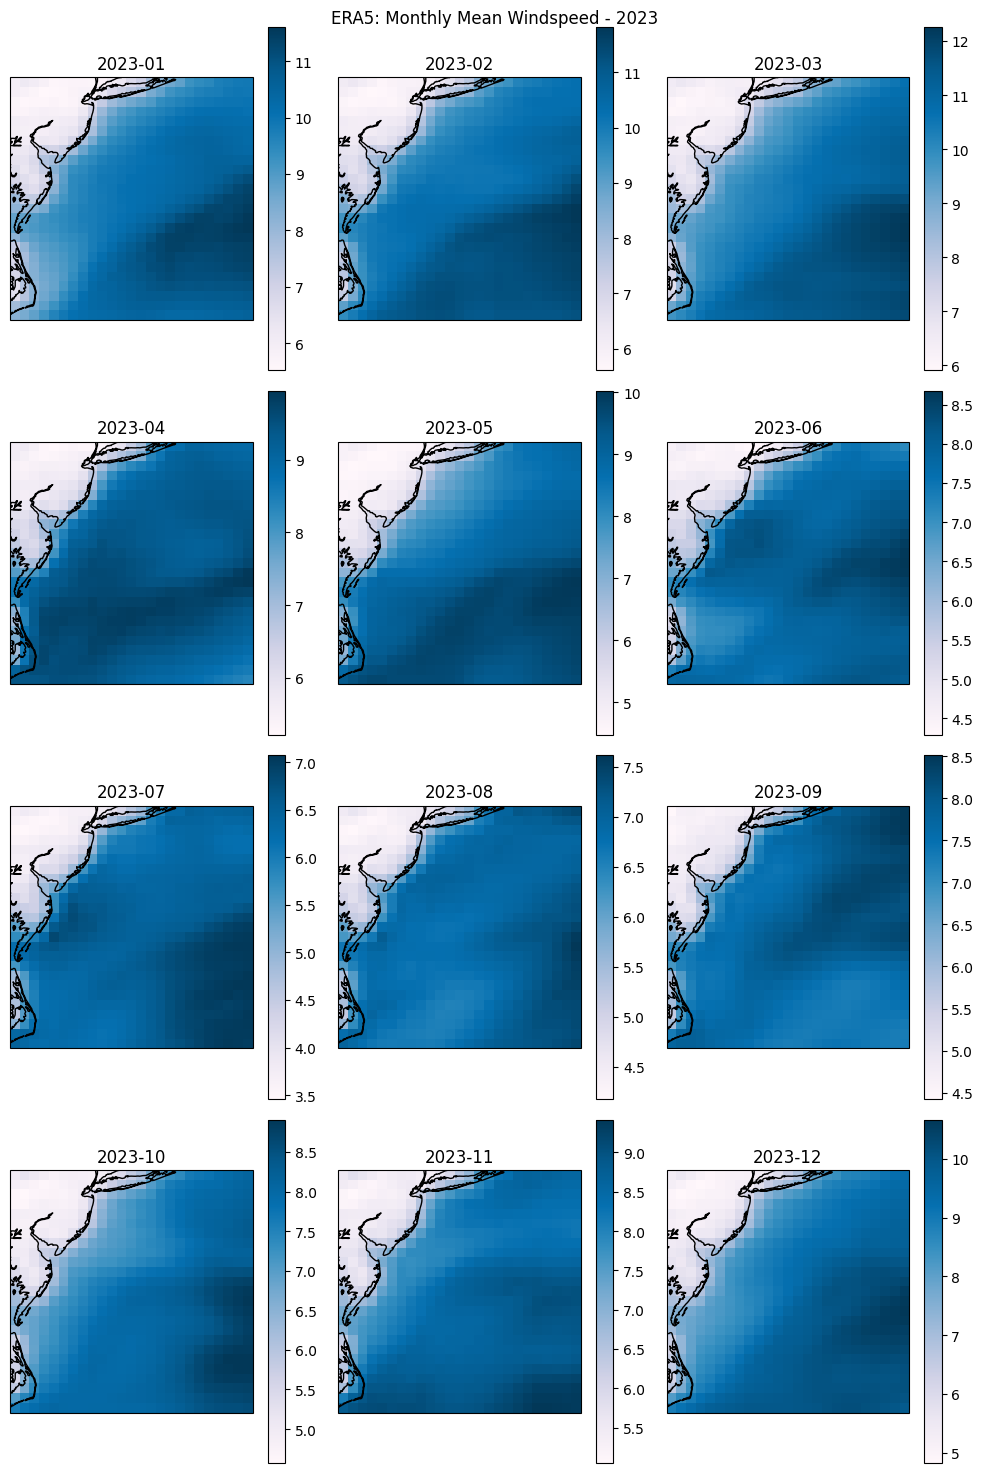

In [7]:
fig, axs = plt.subplots(4,3,figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax = axs.flatten()

for i, mon in enumerate(monmn_windspeed.time.values):
    print(f'Working on {mon}')
    plot = monmn_windspeed.sel(time=mon).plot(ax=ax[i], cmap='PuBu')
    plot.set_label('m/s')

    ax[i].coastlines()
    ax[i].set_title(str(mon)[0:7])

plt.suptitle('ERA5: Monthly Mean Windspeed - 2023')
plt.tight_layout()

In [25]:
def calc_windspeed_time_window(ds, start_time, end_time):
    """Calculate windspeed within time window. 
    Inputs: 
        ds: Xarray Dataset containing the "100m_u_component_of_wind" and 
            "100m_v_component_of_wind" variables 
        start_time: string representing start time ('YYYY-MM-DD')
        end_time: string representing end time ('YYYY-MM-DD')
    Returns: 
        windspeed: Xarray DataArray containing windspeed within time window. 
    """
    ds_window = ds.sel(time=slice(start_time, end_time))

    windspeed = kwindy.calc_windspeed(
        ds_window["100m_u_component_of_wind"], 
        ds_window["100m_v_component_of_wind"]
    )
    windspeed = windspeed.chunk({'time':-1})
    return windspeed

### Select a single point to calculate weibull fit: 

In [8]:
era5_single_point = era5_USeast.isel(latitude=10, longitude=10)

In [26]:
start_time = '1980-01-01'
end_time = '1981-01-01'

windspeed = calc_windspeed_time_window(era5_single_point, start_time, end_time)

In [15]:
shape, loc, scale = kwindy.fit_weibull_xarray(windspeed, 'time')

weibull_params = {
    'shape': shape.compute().values,
    'loc': loc.compute().values,
    'scale': scale.compute().values
}

In [16]:
weibull_dict['1980'] = weibull_params

NameError: name 'weibull_dict' is not defined

In [18]:
weibull_params['shape'].values

array(2.1101748)

Text(0.5, 1.0, 'Weibull Distribution: Windspeed')

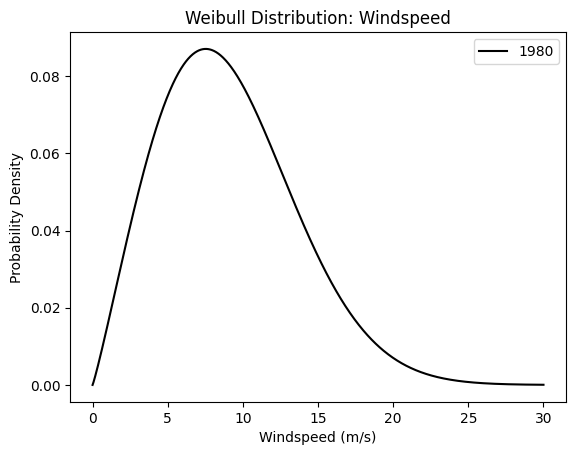

In [23]:
from scipy.stats import weibull_min

x = np.linspace(0, 30, 1000)
y = weibull_min.pdf(
    x, 
    weibull_params['shape'].values, 
    weibull_params['loc'].values, 
    weibull_params['scale'].values
    )

plt.plot(x, y, color='k',label="1980")
plt.legend()
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Probability Density')
plt.title('Weibull Distribution: Windspeed')